# Data Mining Project - Touristic Hotspot in Lyon


## Download and import library

In [1]:
# Installation des dépendances nécessaires
!pip3 install numpy==1.26.0 pandas==2.1.1 scikit-learn==1.5.1 scipy==1.12.0 \
    plotly==5.24.1 matplotlib==3.8.0 seaborn==0.13.2 plotly-express==0.4.1 \
    chart-studio==1.1.0 streamlit==1.37.1 mlxtend==0.23.3 \
    nltk networkx geopy folium wordcloud

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from scipy.spatial import ConvexHull

import os
import webbrowser
import re

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from geopy.distance import great_circle
import networkx as nx

/Users/simonperret/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/simonperret/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/simonperret/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simonperret/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/simonperret/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preparing data for analysis
### Cleaning Data

In [3]:
# Load the dataset
data = pd.read_csv("../data/dataset.csv", sep=",", low_memory=False)
print(f"Initial dimensions: {data.shape}")

# Clean column names
data.columns = data.columns.str.strip()

# Remove "Unnamed" columns created due to incorrect formatting :
# column because of certain photo titles containing commas and 
# therefore shifting all the columns. We are deleting these columns 
# and the rows concerned will be deleted later because they will be badly formatted. 
data = data.drop(columns=["Unnamed: 16", "Unnamed: 17", "Unnamed: 18"], errors='ignore')

# Remove unnecessary columns
data = data.drop(columns=["date_upload_minute", "date_upload_hour", "date_upload_day", "date_upload_month","date_upload_year"])

# Remove rows that have neither tags nor titles
data = data.dropna(subset=['tags', 'title'], how='all')

# Remove duplicates
data = data.drop_duplicates(keep='first')
print(f"After removing duplicates: {data.shape}")


# Function to normalize incorrectly formatted dates
def normalize_date(year, month, day, hour, minute):
    try:
        return pd.to_datetime(f"{int(year)}-{int(month)}-{int(day)} {int(hour)}:{int(minute)}", errors='coerce')
    except ValueError:
        return np.nan  # Replace invalid dates with NaN

# Apply date normalization
data['date_taken'] = data.apply(
    lambda row: normalize_date(row['date_taken_year'], row['date_taken_month'], row['date_taken_day'],
                               row['date_taken_hour'], row['date_taken_minute']), axis=1)

# Remove rows with invalid dates
data = data.dropna(subset=['date_taken'])
data = data.drop(columns=["date_taken_minute", "date_taken_hour", "date_taken_day", "date_taken_month", "date_taken_year"])

print(f"After correcting and removing invalid dates: {data.shape}")

# Geographic filtering (Lyon area)
validation_rules = {
    'lat': lambda x: pd.api.types.is_number(x) and 45.614067767464974 <= x <= 45.88380569722158,
    'long': lambda x: pd.api.types.is_number(x) and 4.655505238288724 <= x <= 5.042868327562071,
}

# Clean geographic coordinates
data['lat'] = pd.to_numeric(data['lat'], errors='coerce')
data['long'] = pd.to_numeric(data['long'], errors='coerce')
data = data.dropna(subset=['lat', 'long'])

print(f"After removing out-of-bounds rows: {data.shape}")


Initial dimensions: (420240, 19)
After removing duplicates: (157967, 11)
After correcting and removing invalid dates: (157917, 7)
After removing out-of-bounds rows: (157917, 7)


### Saving cleaned data in a new `csv` file

In [4]:
data_path = "../data/datasetCleaned.csv"
data.to_csv(data_path, index=False)
print("Dataset saved in 'data/datasetCleaned.csv'")

Dataset saved in 'data/datasetCleaned.csv'


Now that the data has been thoroughly cleaned by removing missing values, duplicates, and properly structuring the information, we can proceed with an initial exploration of the dataset.

The goal is to conduct some descriptive statistical analyses to better understand the distribution of the data, identify key trends, and detect any interesting patterns. We will examine the temporal and spatial distribution of photos, the most active users, and the most frequent keywords.

These initial observations will help refine our approach before applying more advanced clustering and semantic analysis techniques.

## Descriptive Statistics
### Number of photos per year

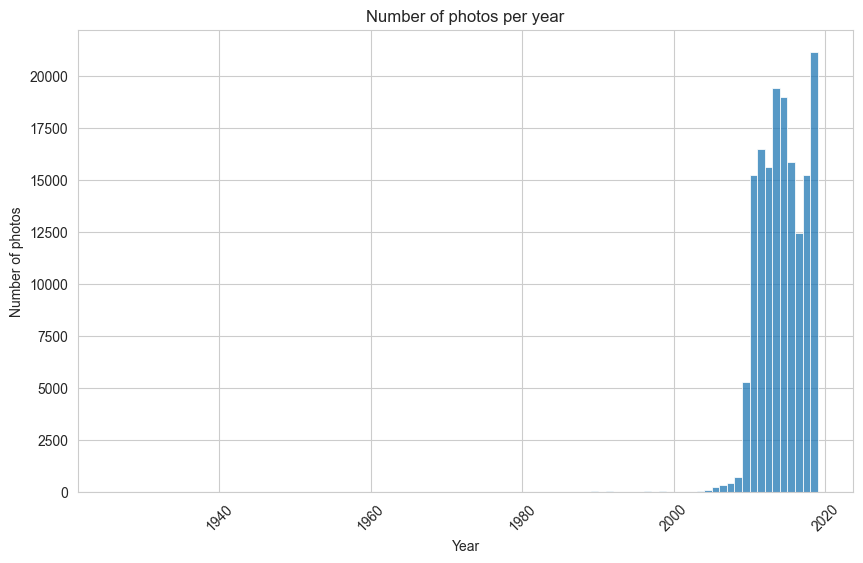

In [5]:
data = pd.read_csv("../data/datasetCleaned.csv", parse_dates=['date_taken'])

# Adjust figure size for better visualization
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

# Histogram of the number of photos per year
plt.figure()
data['year'] = data['date_taken'].dt.year
sns.histplot(data['year'], bins=range(data['year'].min(), data['year'].max() + 1), kde=False)
plt.title("Number of photos per year")
plt.xlabel("Year")
plt.ylabel("Number of photos")
plt.xticks(rotation=45)
plt.show()

### Number of photos per month

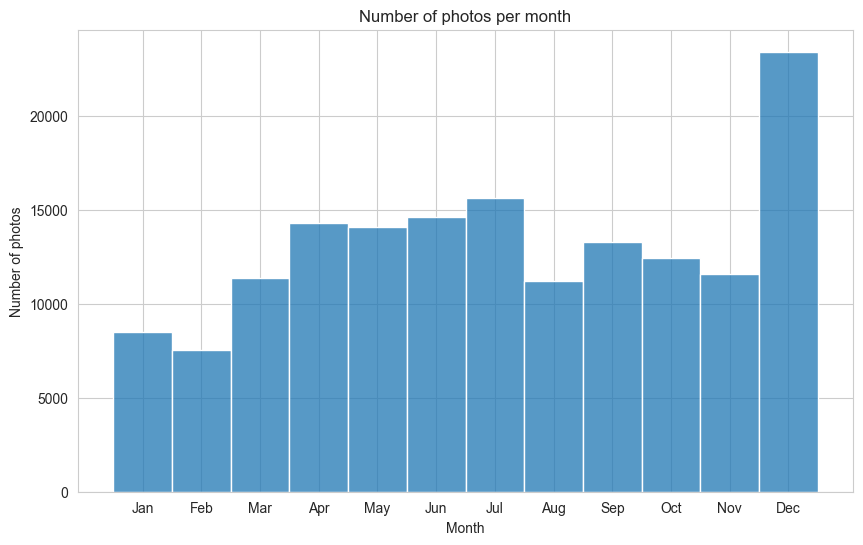

In [6]:
# Histogram of the number of photos per month
plt.figure()
data['month'] = data['date_taken'].dt.month
sns.histplot(data['month'], bins=12, kde=False, discrete=True)
plt.title("Number of photos per month")
plt.xlabel("Month")
plt.ylabel("Number of photos")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

### Number of photos in December per day

/var/folders/fk/_hwth5xs3mx2mqbv_9vhvypm0000gn/T/ipykernel_28571/4040727547.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  december_data['day'] = december_data['date_taken'].dt.day


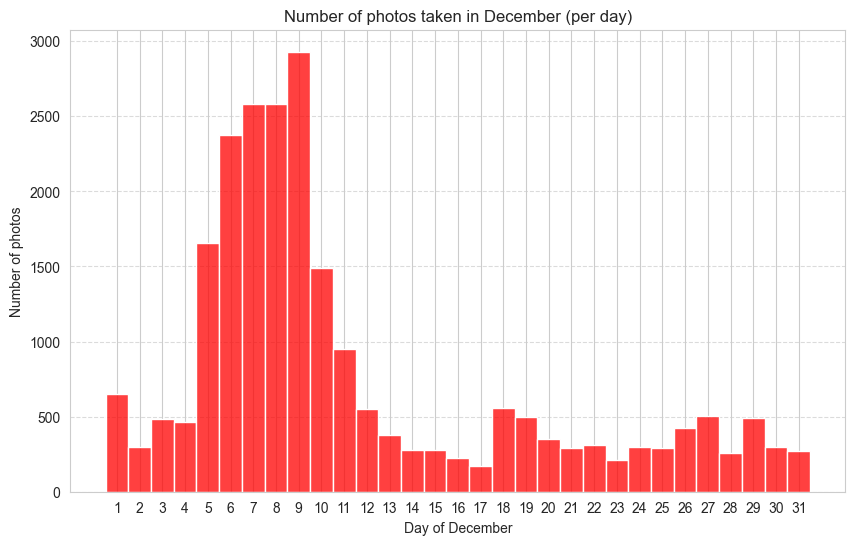

In [7]:
# Number of photos taken in December (per day)
december_data = data[data['date_taken'].dt.month == 12]

plt.figure(figsize=(10, 6))
december_data['day'] = december_data['date_taken'].dt.day
sns.histplot(december_data['day'], bins=31, kde=False, discrete=True, color='red')
plt.title("Number of photos taken in December (per day)")
plt.xlabel("Day of December")
plt.ylabel("Number of photos")
plt.xticks(range(1, 32))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Number of photos per hour

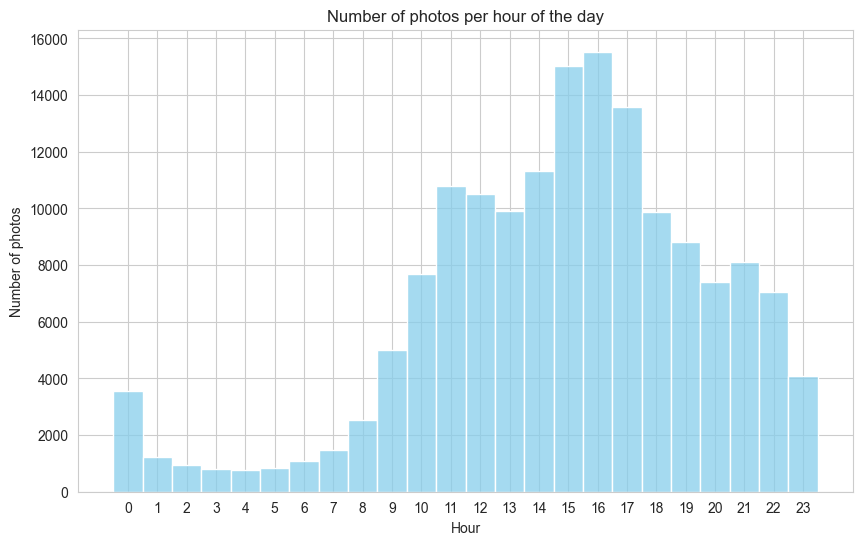

In [8]:
# Histogram of the number of photos per hour of the day
plt.figure()
data['hour'] = data['date_taken'].dt.hour
sns.histplot(data['hour'], bins=24, kde=False, discrete=True, color='skyblue')
plt.title("Number of photos per hour of the day")
plt.xlabel("Hour")
plt.ylabel("Number of photos")
plt.xticks(range(0, 24))
plt.show()

### 10 best user

/var/folders/fk/_hwth5xs3mx2mqbv_9vhvypm0000gn/T/ipykernel_28571/3926547262.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.values, y=top_users.index, palette="viridis")


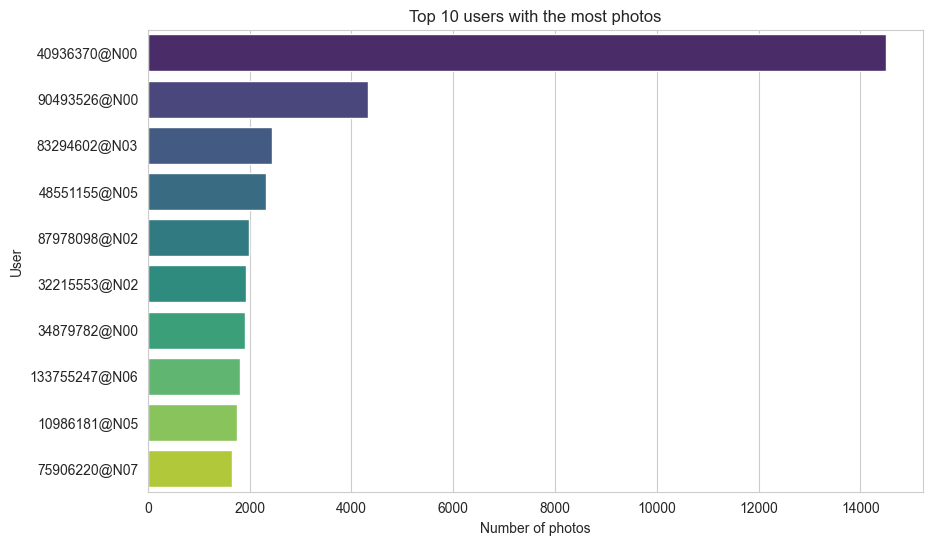

In [9]:
# Top 10 users with the most photos
plt.figure()
top_users = data['user'].value_counts().head(10)
sns.barplot(x=top_users.values, y=top_users.index, palette="viridis")
plt.title("Top 10 users with the most photos")
plt.xlabel("Number of photos")
plt.ylabel("User")
plt.show()

### Heatmap of photo density

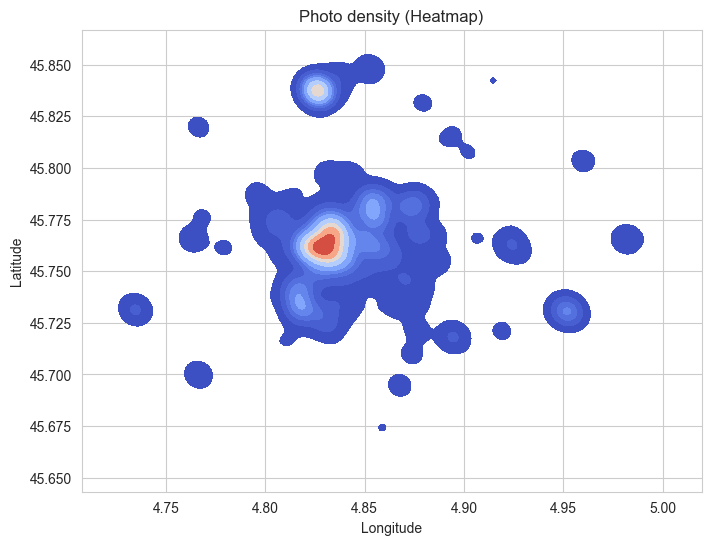

In [10]:
# Heatmap of photo density (2D Heatmap)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=data['long'], y=data['lat'], cmap="coolwarm", fill=True)
plt.title("Photo density (Heatmap)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

With a better understanding of the dataset through descriptive analysis, we can now move on to clustering techniques to identify meaningful patterns in the data.

We will apply three clustering algorithms commonly used in data analysis:

- **K-Means Clustering** – A partitioning method that groups data into a predefined number of clusters based on similarity.
- **Hierarchical Clustering** – A method that builds a tree-like structure of clusters, allowing us to explore different levels of grouping.
- **DBSCAN** – A density-based algorithm that identifies clusters of varying shapes and sizes while effectively handling noise points.

Each approach has its advantages and limitations, and we will compare their results to determine the most suitable method for our dataset.


## Discovering areas of interests using clustering
### Loading data from `datasetCleaned.csv`

In [11]:
print("Loading data...")
data_path = "../data/datasetCleaned.csv"
df = pd.read_csv(data_path, low_memory=False)
print("Data loaded")

Loading data...
Data loaded


### KMeans Clustering
#### Elbow Method

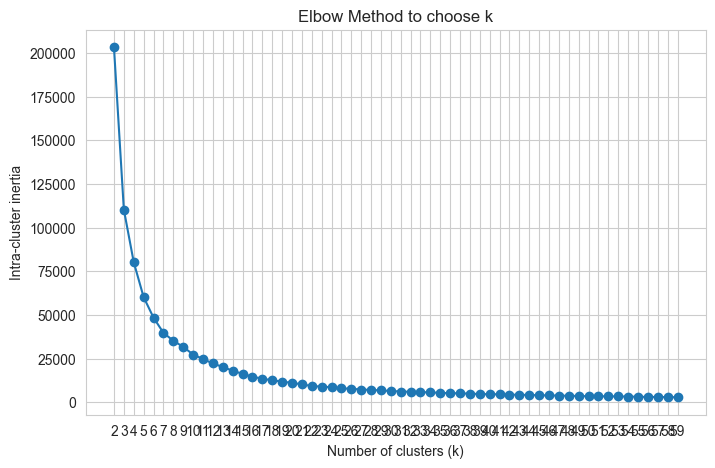

In [12]:
# Extract geographic coordinates
X = df[['lat', 'long']].values

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Test different numbers of clusters
inertia = []
k_values = range(2, 60)  # Test between 2 and 15 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # Intra-cluster inertia

# Plot the Elbow Method curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Intra-cluster inertia')
plt.title("Elbow Method to choose k")
plt.xticks(k_values)
plt.grid(True)
plt.show()

The Elbow Method provides an estimation of the optimal number of clusters, but in this case, it suggests a relatively low number of clusters, which may not fully capture the complexity of the dataset. Additionally, the computation time is significantly long due to the iterative nature of K-Means, making it impractical for large datasets. Therefore, we will define a reasonable number of clusters based on prior knowledge and observations.

#### Apply the KMeans Clustering

In [13]:
dfKMeans = df
print("Applying K-Means...")
X = dfKMeans[['lat', 'long']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=50, random_state=42, n_init=10)
dfKMeans['cluster'] = kmeans.fit_predict(X_scaled)
print(f"K-Means completed with {len(set(dfKMeans['cluster']))} clusters")

# Create Folium map
print("Creating Folium map...")
map_clusters = folium.Map(location=[45.75, 4.85], zoom_start=13)

# Generate colors for clusters
cluster_colors = [
    f"#{''.join(np.random.choice(list('0123456789ABCDEF'), 6))}"
    for _ in range(len(dfKMeans['cluster'].unique()))
]

# Add points to the map
for _, row in dfKMeans.iterrows():
    cluster_id = row['cluster']
    color = cluster_colors[cluster_id]
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.5
    ).add_to(map_clusters)
    
# Save and open the map
map_file = "../output/clusteringKMeans.html"
map_clusters.save(map_file)
print(f"Map saved in {map_file}")

# Open the map automatically in the browser
webbrowser.open(f'file:///{os.path.abspath(map_file)}')

print("Map ready")

Applying K-Means...
K-Means completed with 50 clusters
Creating Folium map...
Map saved in ../output/clusteringKMeans.html
Map ready


K-Means is effective at partitioning the dataset, but it assigns every point to a cluster, even in areas where no clear structure exists. As a result, some clusters become very large, making it difficult to identify precise points of interest. This method lacks the ability to distinguish outliers and dense areas effectively.

### Hierarchical Clustering

In [14]:
dfHierarchical = df

# Reduce density by random sampling (keep only 20% of points)
dfHierarchical = dfHierarchical.sample(frac=0.2, random_state=42)
print(f"Data size after sampling: {len(dfHierarchical)} points")

# Apply Hierarchical Clustering
print("Applying Hierarchical Clustering...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dfHierarchical[['lat', 'long']])

n_clusters = 25
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
dfHierarchical['cluster'] = clustering.fit_predict(X_scaled)
print(f"Clustering completed with {n_clusters} clusters")

# Create Folium map
print("Creating Folium map...")
map_clusters = folium.Map(location=[45.75, 4.85], zoom_start=13)

# Generate unique colors for each cluster
cluster_colors = [
    f"#{''.join(np.random.choice(list('0123456789ABCDEF'), 6))}"
    for _ in range(len(dfHierarchical['cluster'].unique()))
]

# Add cluster points
for _, row in dfHierarchical.iterrows():
    cluster_id = row['cluster']
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=5,
        color=cluster_colors[cluster_id],
        fill=True,
        fill_opacity=0.5,
        popup=f"Cluster {cluster_id}"
    ).add_to(map_clusters)

# Save and open the map
map_file = "../output/clustersHierarchical.html"
map_clusters.save(map_file)
print(f"Map saved in {map_file}")

# Open the map automatically in the browser
webbrowser.open(f'file:///{os.path.abspath(map_file)}')

print("Map ready")

Data size after sampling: 31583 points
Applying Hierarchical Clustering...
Clustering completed with 25 clusters
Creating Folium map...
Map saved in ../output/clustersHierarchical.html
Map ready


Hierarchical clustering provides a more interpretable structure by creating a hierarchy of clusters, but it struggles with large datasets due to its high computational cost. Additionally, it does not handle noise well, and choosing the optimal number of clusters is not always straightforward. This method is better suited for small-scale applications rather than large geospatial datasets.

### DBSCAN Clustering

In [15]:
dfDBSCAN = df

# Sampling to improve performance (reduce density)
dfDBSCAN = dfDBSCAN.sample(frac=0.1, random_state=42)  # Keep only 10% of points
print(f"Data size after sampling: {len(dfDBSCAN)} points")

# Apply DBSCAN clustering
print("Applying DBSCAN...")
X = dfDBSCAN[['lat', 'long']].values

eps = 0.0002
min_samples = 10
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dfDBSCAN['cluster'] = dbscan.fit_predict(X)

# Compute cluster statistics
n_clusters = len(set(dfDBSCAN['cluster'])) - (1 if -1 in dfDBSCAN['cluster'] else 0)
n_noise = sum(dfDBSCAN['cluster'] == -1)
print(f"Clustering completed with: {n_clusters} clusters")
print(f"Clustering completed with: {n_noise} noise points")

# Create Folium map
print("Creating Folium map...")
map_clusters = folium.Map(location=[45.75, 4.85], zoom_start=13)

# Generate unique colors for each cluster
cluster_colors = ['#808080']  # Gray for noise points
cluster_colors += [
    f"#{''.join(np.random.choice(list('0123456789ABCDEF'), 6))}"
    for _ in range(n_clusters)
]

# Add cluster points
for _, row in dfDBSCAN.iterrows():
    cluster_id = row['cluster']
    color_idx = cluster_id + 1 if cluster_id >= 0 else 0  # Gray for noise
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=3,
        color=cluster_colors[color_idx],
        stroke=False if cluster_id < 0 else True,
        fill=True,
        fill_opacity=0.5 if cluster_id >= 0 else 0.6
    ).add_to(map_clusters)

cluster_centroids = {}

# Add convex hulls for clusters
for cluster_id in range(n_clusters):
    cluster_points = dfDBSCAN[dfDBSCAN['cluster'] == cluster_id][['lat', 'long']].values
    unique_points = np.unique(cluster_points, axis=0)  # Remove duplicate points

    if len(unique_points) >= 3:  # A polygon requires at least 3 distinct points
        try:
            hull = ConvexHull(unique_points)
            hull_points = unique_points[hull.vertices]

            # Compute the centroid of the cluster (average of hull points)
            centroid_lat = np.mean(hull_points[:, 0])
            centroid_long = np.mean(hull_points[:, 1])
            cluster_centroids[cluster_id] = (centroid_lat, centroid_long)  # Store coordinates

            # Ensure the centroids are correctly formatted as floats
            cluster_centroids = {
                cluster_id: (float(lat), float(long)) 
                for cluster_id, (lat, long) in cluster_centroids.items()
                if isinstance(lat, (float, int)) and isinstance(long, (float, int))
            }

            # Add the polygon to the map
            folium.Polygon(
                locations=[[point[0], point[1]] for point in hull_points],
                color=cluster_colors[cluster_id + 1],
                weight=2,
                fill=True,
                fill_color=cluster_colors[cluster_id + 1],
                fill_opacity=0.2
            ).add_to(map_clusters)

        except Exception as e:
            print(f"Error creating polygon for cluster {cluster_id}: {e}")

# Save and open the map
map_file = "../output/clusteringDBSCAN.html"
map_clusters.save(map_file)
print(f"Map saved in {map_file}")

# Open the map automatically in the browser
webbrowser.open(f'file:///{os.path.abspath(map_file)}')

print("Map ready")

Data size after sampling: 15792 points
Applying DBSCAN...
Clustering completed with: 161 clusters
Clustering completed with: 7267 noise points
Creating Folium map...
Map saved in ../output/clusteringDBSCAN.html
Map ready


DBSCAN stands out as the most effective method for our dataset. By using a density-based approach, it successfully identifies precise points of interest while filtering out noise. To improve performance and maintain efficiency, we applied DBSCAN to a 10% sample of the data, as this already provided highly satisfactory results. Given its ability to detect meaningful clusters without forcing all points into a group, we will use DBSCAN for the rest of the analyses.

### Saving the best Clustering in a new `csv` file

In [16]:
bestClustering = dfDBSCAN

clustered_csv_path = "../data/clusteredData.csv"
bestClustering.to_csv(clustered_csv_path, index=False)
print(f"Clustered data saved in: {clustered_csv_path}")

Clustered data saved in: ../data/clusteredData.csv


Now that we have identified relevant clusters using DBSCAN, we will move on to text mining analysis. This step will help us understand the nature of each cluster by extracting meaningful keywords from image titles and tags. By analyzing the most frequent and relevant words, we aim to gain insights into the themes and points of interest captured in the dataset.

## Description of areas of interest using text pattern mining

### Load data

In [17]:
# Load the dataset containing tags
data_path = "../data/clusteredData.csv"
dfTP = pd.read_csv(data_path, low_memory=False)

# Display some raw tags
dfTP[['tags', 'title']].head(10)

,tags,title
0,"cactus,plante,lyon",IMG_9844
1,"froid,partdieu,gratteciel,pollution,hiver,mati...",Pollution sur lyon
2,"dalbera,ben,magasin,lyon,muséedartcontemporain...",Le Bizart Baz'art de Ben (musée d'art contempo...
3,"lyon,full,moon,city",Harvest Moon
4,NaN,Cosplay Disney Show
5,"france,line,ligne,courbe,curve,géométrie,geome...",Grille épaisse
6,"square,squareformat,perpetua,iphoneography,ins...",Ça va doser large #sfv #retro
7,"streetart,france,pasteup,collage,paper,europe,...","Pasted paper by Quetzilla [Lyon, France]"
8,69,"Lyon (Rhône), basilique St-Martin d'Ainay (45)"
9,"lyon,basilica",Mosaic


### Stopwords in french and english

In [18]:
# Define stopwords in French and English
stop_words = set(stopwords.words('french') + stopwords.words('english'))

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text, stop_words):
    if pd.isna(text):  # Handle missing values
        return ""

    # Convert to lowercase
    text = text.lower()

    # Replace commas with spaces to prevent words from sticking together
    text = text.replace(",", " ")

    # Remove special characters and numbers (but keep spaces)
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)

    # Tokenization
    words = word_tokenize(text)

    # Remove stopwords and apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Reconstruct the text
    return " ".join(words).strip()

# Clean titles and tags
dfTP['cleaned_title'] = dfTP['title'].fillna('').apply(lambda x: clean_text(x, stop_words))
dfTP['cleaned_tags'] = dfTP['tags'].fillna('').apply(lambda x: clean_text(x, stop_words))

# Display results after cleaning
dfTP[['cleaned_title', 'cleaned_tags']].head(10)

,cleaned_title,cleaned_tags
0,img,cactus plante lyon
1,pollution lyon,froid partdieu gratteciel pollution hiver mati...
2,bizart bazart ben musée dart contemporain lyon,dalbera ben magasin lyon muséedartcontemporain...
3,harvest moon,lyon full moon city
4,cosplay disney show,
5,grille épaisse,france line ligne courbe curve géométrie geome...
6,ça va doser large sfv retro,square squareformat perpetua iphoneography ins...
7,pasted paper quetzilla lyon france,streetart france pasteup collage paper europe ...
8,lyon rhône basilique stmartin dainay,
9,mosaic,lyon basilica


### Lemmatization

In [19]:
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to a cleaned text.
def lemmatize_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

# Apply lemmatization
dfTP['lemmatized_title'] = dfTP['cleaned_title'].apply(lemmatize_text)
dfTP['lemmatized_tags'] = dfTP['cleaned_tags'].apply(lemmatize_text)

# Display results after lemmatization
dfTP[['lemmatized_title', 'lemmatized_tags']].head(10)

,lemmatized_title,lemmatized_tags
0,img,cactus plante lyon
1,pollution lyon,froid partdieu gratteciel pollution hiver mati...
2,bizart bazart ben musée dart contemporain lyon,dalbera ben magasin lyon muséedartcontemporain...
3,harvest moon,lyon full moon city
4,cosplay disney show,
5,grille épaisse,france line ligne courbe curve géométrie geome...
6,ça va doser large sfv retro,square squareformat perpetua iphoneography ins...
7,pasted paper quetzilla lyon france,streetart france pasteup collage paper europe ...
8,lyon rhône basilique stmartin dainay,
9,mosaic,lyon basilica


### Wordcloud

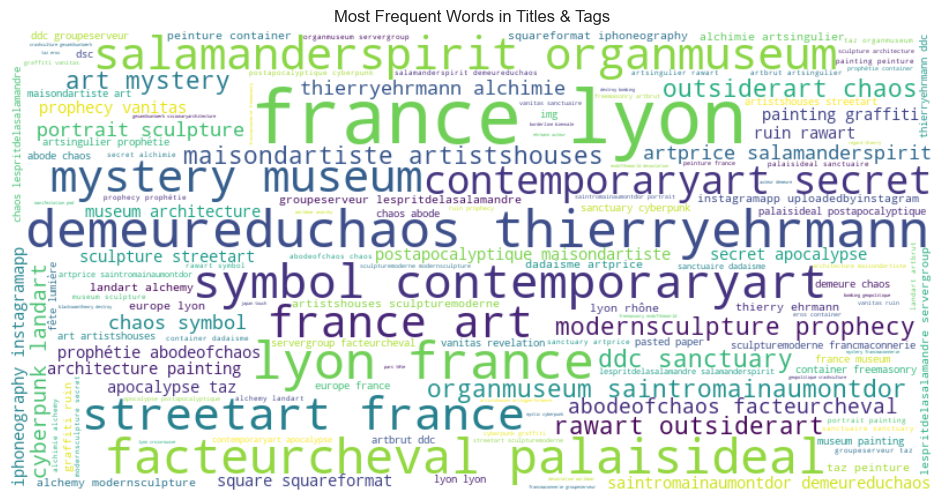

In [20]:
# Concatenate all titles and tags
all_text = " ".join(dfTP['lemmatized_title'].dropna()) + " " + " ".join(dfTP['lemmatized_tags'].dropna())

# Generate the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

# Display the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Titles & Tags")
plt.show()


### Apply TF-IDF

In [21]:
# Exclude noisy clusters (-1)
dfTP = dfTP[dfTP['cluster'] != -1]

# Merge text columns
dfTP['combined_text'] = dfTP['cleaned_title'].fillna('') + " " + dfTP['cleaned_tags'].fillna('')


dfTP[['id', 'lat', 'long', 'date_taken', 'cluster', 'combined_text']].to_csv("../data/cleanedTextData.csv", index=False)

# Group texts by cluster
cluster_texts = dfTP.groupby('cluster')['combined_text'].apply(lambda x: ' '.join(x)).reset_index()

# List of words to exclude
excluded_words = {"lyon", "france", "image", "img", "photo", "flickr", "city", "picture", "rhône", "alpes",
                  "ville", "tourism", "urban", "travel", "place", "dsc", "dor", "imgjpg", "fr", "sec", 
                  "iphoneography", "uploadedbyinstagram", "instagramapp", "instagram", "frankreich", 
                  "rhônealpes", "auvergnerhônealpes", "frankrijk", "francia", "frança"}

# Apply TF-IDF while excluding stopwords
vectorizer = TfidfVectorizer(max_features=500, min_df=5, max_df=0.6, stop_words=list(excluded_words))
tfidf_matrix = vectorizer.fit_transform(cluster_texts['combined_text'])

# Retrieve keywords for each cluster
feature_names = vectorizer.get_feature_names_out()
cluster_keywords = {}

for cluster_id, row in enumerate(tfidf_matrix.toarray()):
    top_keywords = [feature_names[i] for i in row.argsort()[-5:][::-1]]  # Top 5 keywords
    cluster_keywords[cluster_texts.iloc[cluster_id]['cluster']] = ", ".join(top_keywords)

# Display results
for cluster, keywords in cluster_keywords.items():
    print(f"Cluster {cluster}: {keywords}")


Cluster 0: parcdelatêtedor, tête, parc, flower, secret
Cluster 1: fourvière, basilique, basilica, notredame, fourviere
Cluster 2: cosplay, japan, international, show, église
Cluster 3: zombie, walk, croixrousse, europe, nuit
Cluster 4: basilique, roman, eglise, basilica, aquarelle
Cluster 5: bellecour, placebellecour, lumières, fête, europe
Cluster 6: zombie, croixrousse, pasted, paper, walk
Cluster 7: ddc, demeureduchaos, abodeofchaos, thierryehrmann, alchemy
Cluster 8: passage, photographie, mai, juin, photographe
Cluster 9: squareformat, square, friend, coffee, rise
Cluster 10: opera, lumières, hôtel, fêtedeslumières, fête
Cluster 11: vieux, rue, filoer, vieuxlyon, villes
Cluster 12: ddc, abodeofchaos, rawart, taz, container
Cluster 13: terreaux, musée, fontaine, art, lumières
Cluster 14: rhonealpes, rhone, église, francie, fransa
Cluster 15: justice, palais, passerelle, statue, lumières
Cluster 16: musée, vieuxlyon, monlyon, museum, musee
Cluster 17: biennale, musée, artcontemporai

Now that we have completed the text mining steps, the extracted cluster names appear to be highly relevant. This allows us to visualize them directly on the map, making it easier to interpret the different areas of interest identified in the dataset. By labeling each cluster with meaningful keywords, we enhance the clarity and usability of our geographic analysis.

 ### Adding cluster names to the map

In [22]:
# Compute cluster centroids
cluster_centroids = dfTP.groupby('cluster')[['lat', 'long']].mean().to_dict(orient='index')

# Add cluster names to the map
def add_cluster_names_to_map(cluster_centroids, cluster_names, map_object):
    """
    Adds cluster names based on the identified keywords on polygons.
    """
    for cluster_id, coords in cluster_centroids.items():
        centroid_lat, centroid_long = coords['lat'], coords['long']
        name = cluster_names.get(cluster_id, f"Cluster {cluster_id}")  # Cluster name

        folium.Marker(
            location=[centroid_lat, centroid_long],
            tooltip=f"<b>{name}</b>",  # Display name on hover
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(map_object)  # Add marker at centroid

# Apply the function to the existing map
add_cluster_names_to_map(cluster_centroids, cluster_keywords, map_clusters)

# Save the updated map
map_clusters.save("../output/clusteringDBSCAN.html")

# Automatically open the updated map
webbrowser.open(f'file:///{os.path.abspath("../output/clusteringDBSCAN.html")}') 

True

With well-defined cluster names, we can now investigate the relationship between spatial and temporal patterns. By analyzing how certain areas of interest evolve over time, we aim to identify recurring events, seasonal trends, or one-time occurrences. This will provide deeper insights into how activity in Lyon changes across different periods.

## Events: study of dense areas though time and space

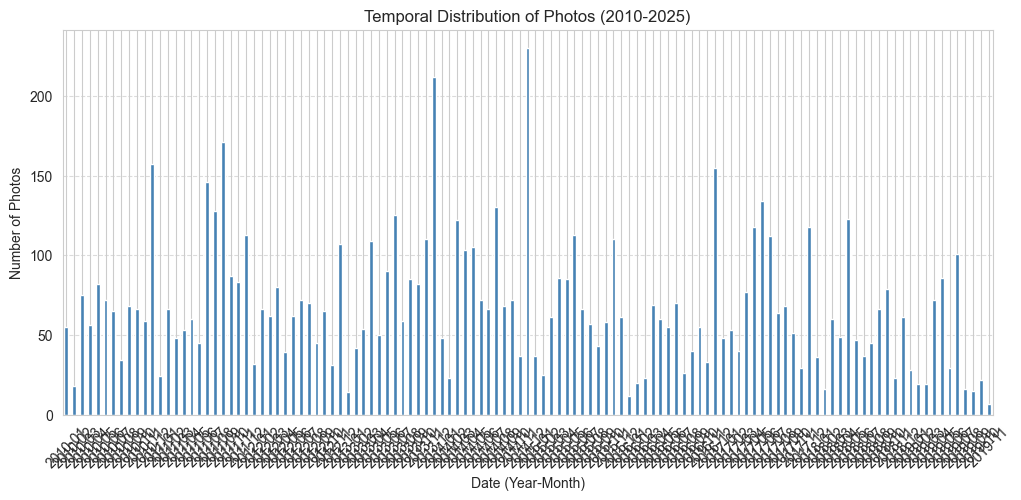

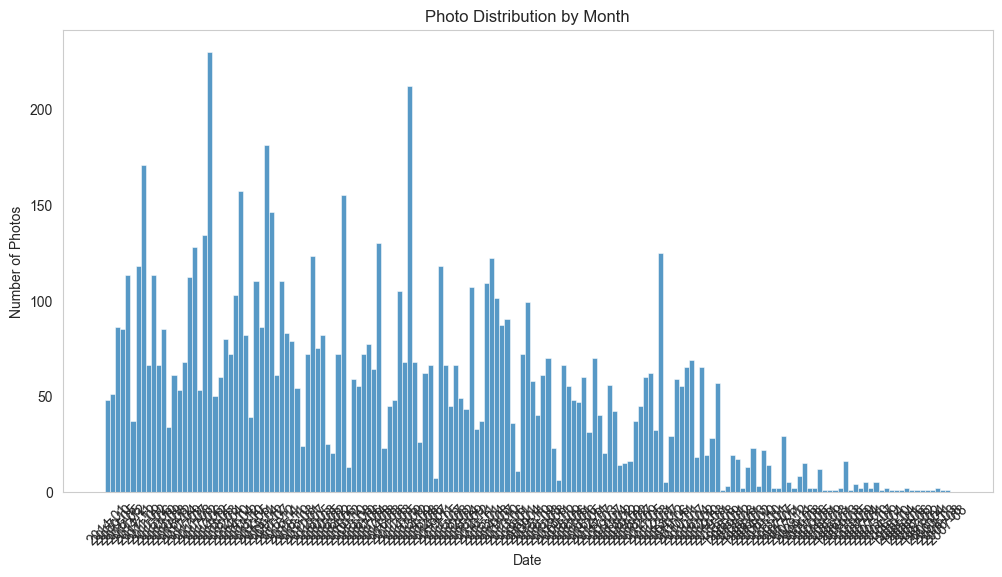

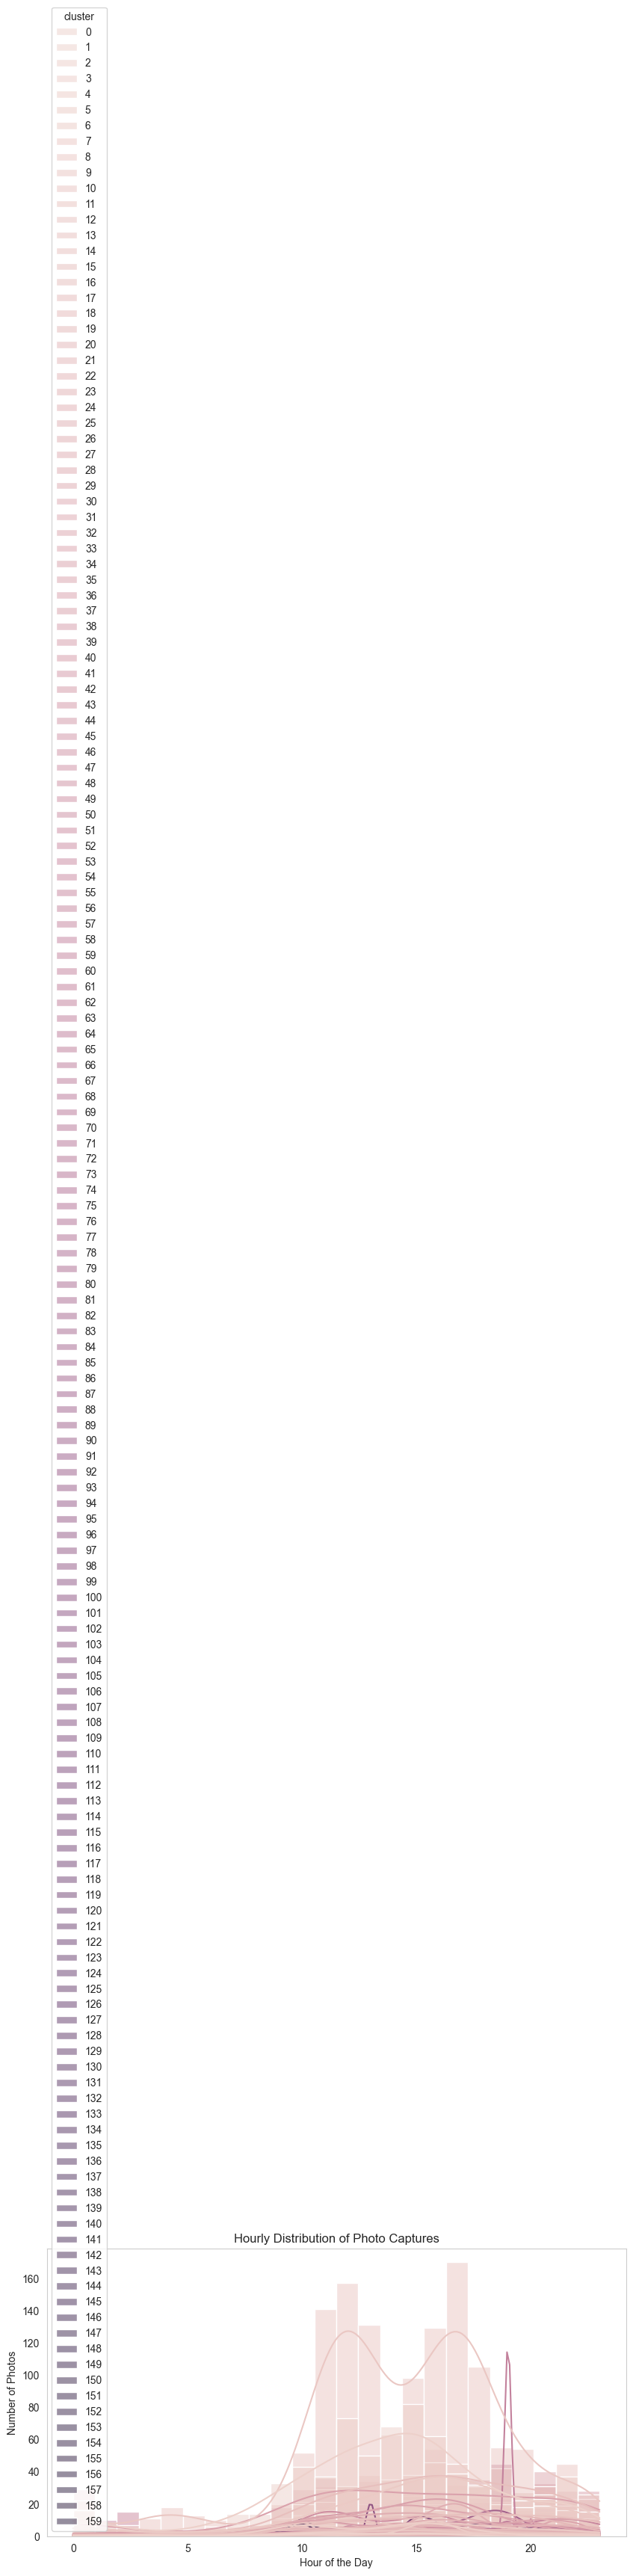

<Figure size 1400x600 with 0 Axes>

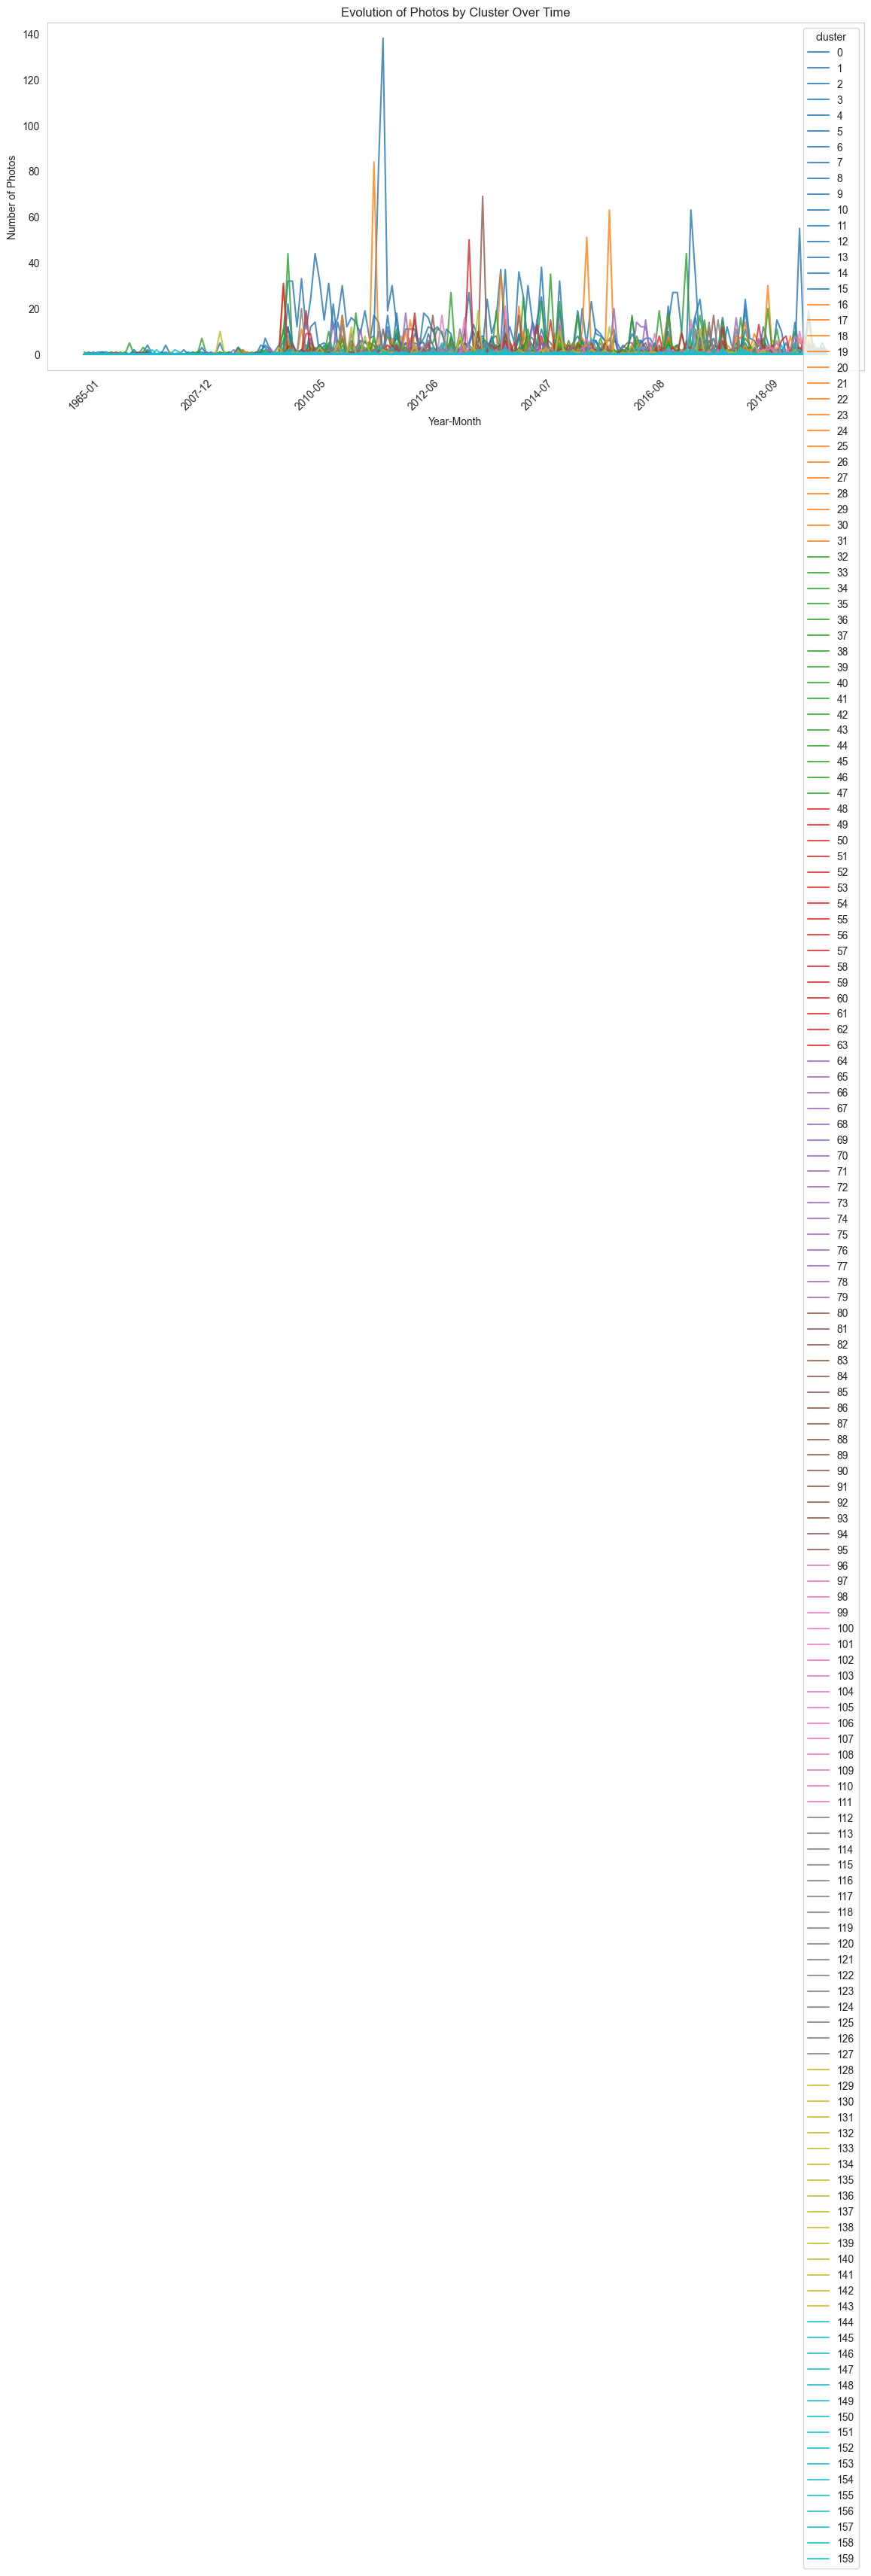

In [23]:
# Load the clustered dataset
data_path = "../data/clusteredData.csv"
df_clustered = pd.read_csv(data_path, low_memory=False, parse_dates=['date_taken'])

# Ensure 'date_taken' is in datetime format
df_clustered['date_taken'] = pd.to_datetime(df_clustered['date_taken'], errors='coerce')

# Exclude noise (-1 clusters) for cleaner analysis
df_clustered = df_clustered[df_clustered['cluster'] != -1]

### Temporal distribution of photos (2010-2025) ###
df_time = df_clustered.copy()
df_time = df_time[(df_time['date_taken'].dt.year >= 2010) & (df_time['date_taken'].dt.year <= 2025)]

# Extract year-month and count occurrences
df_time['year_month'] = df_time['date_taken'].dt.to_period('M')
photo_counts = df_time['year_month'].value_counts().sort_index()

# Plot the photo distribution over time
plt.figure(figsize=(12, 5))
photo_counts.plot(kind='bar', color='steelblue')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Number of Photos')
plt.title('Temporal Distribution of Photos (2010-2025)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Histogram of the number of photos per month ###
df_month = df_clustered.copy()
df_month['year_month'] = df_month['date_taken'].dt.to_period('M').astype(str)

plt.figure(figsize=(12, 6))
sns.histplot(data=df_month, x="year_month", bins=50, kde=False)
plt.xlabel('Date')
plt.ylabel('Number of Photos')
plt.title('Photo Distribution by Month')
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Hourly distribution of photo captures ###
df_hour = df_clustered.copy()
df_hour['hour'] = df_hour['date_taken'].dt.hour

plt.figure(figsize=(10, 5))
sns.histplot(data=df_hour, x="hour", hue="cluster", bins=24, kde=True)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Photos")
plt.title("Hourly Distribution of Photo Captures")
plt.grid()
plt.show()

### Evolution of clusters over time ###
df_cluster_evolution = df_clustered.copy()
df_cluster_evolution['year_month'] = df_cluster_evolution['date_taken'].dt.to_period('M').astype(str)

df_cluster_time = df_cluster_evolution.groupby(['year_month', 'cluster']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
df_cluster_time.plot(kind='line', colormap='tab10', alpha=0.8, figsize=(14, 6))
plt.ylabel("Number of Photos")
plt.xlabel("Year-Month")
plt.title("Evolution of Photos by Cluster Over Time")
plt.xticks(rotation=45)
plt.grid()
plt.show()

We have explored several graphical representations to analyze temporal trends, but none have provided sufficiently relevant insights. Given the observations from our descriptive analysis, which highlighted a significant concentration of photos taken between December 5 and 10 each year, we will now focus on this specific period. By examining the most frequently occurring keywords and locations during these dates, we aim to uncover potential events or recurring patterns in Lyon.

### New analysis idea: what happens between 5 and 10 december?

Total photos between 12-05 and 12-10: 884
Top 10 words for 12-05 to 12-10:
lumières: 303
fêtedeslumières: 238
fête: 228
light: 153
fetedeslumieres: 110
lione: 104
lumieres: 104
fete: 98
festival: 75
nuit: 75


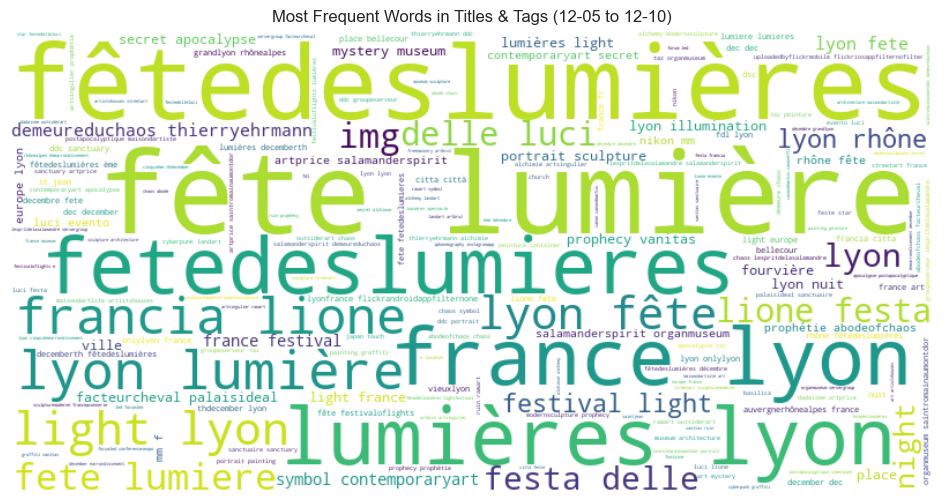

Creating Heatmap for 12-05 to 12-10 photos...
Heatmap saved as ../output/heatmap_12.html


True

In [24]:
# Load the preprocessed dataset with text
data_path = "../data/cleanedTextData.csv"
df = pd.read_csv(data_path, low_memory=False, parse_dates=['date_taken'])

# Ensure 'date_taken' is in datetime format
df['date_taken'] = pd.to_datetime(df['date_taken'], errors='coerce')


df_month = df[(df['date_taken'].dt.month == 12) & (df['date_taken'].dt.day.between(5, 10))]
print(f"Total photos between 12-05 and 12-10: {len(df_month)}")

df_month = df_month.dropna(subset=['combined_text'])

all_text = " ".join(df_month['combined_text'])

excluded_words = {"lyon", "france", "image", "img", "photo", "flickr", "city", "picture", "rhône", "alpes",
                      "ville", "tourism", "urban", "travel", "place", "dsc", "dor", "imgjpg", "fr", "sec",
                      "iphoneography", "uploadedbyinstagram", "instagramapp", "instagram", "frankreich",
                      "rhônealpes", "auvergnerhônealpes", "frankrijk", "francia", "frança"}

vectorizer = CountVectorizer(stop_words=list(excluded_words), max_features=30)
word_matrix = vectorizer.fit_transform([all_text])
word_counts = word_matrix.toarray().sum(axis=0)
top_words = dict(zip(vectorizer.get_feature_names_out(), word_counts))

sorted_words = sorted(top_words.items(), key=lambda x: x[1], reverse=True)

print(f"Top 10 words for 12-05 to 12-10:")
for word, count in sorted_words[:10]:
    print(f"{word}: {count}")

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Most Frequent Words in Titles & Tags (12-05 to 12-10)")
plt.savefig("../img/wordcloudDecember", dpi=300, bbox_inches='tight')
plt.show()


print(f"Creating Heatmap for 12-05 to 12-10 photos...")
map_month = folium.Map(location=[45.75, 4.85], zoom_start=13)
heat_data = df_month[['lat', 'long']].dropna().values.tolist()
HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(map_month)


map_file = f"../output/heatmap_12.html"
map_month.save(map_file)
print(f"Heatmap saved as {map_file}")

webbrowser.open(f'file:///{os.path.abspath(map_file)}') 


Our focused analysis on photos taken between December 5 and 10 has confirmed the presence of the Fête des Lumières during this period. This event strongly correlates with the observed spike in activity. Given this success, we now generalize our approach to allow users to select any date range and discover the most prominent events or activities happening in Lyon during that time. This will be particularly useful for visitors planning a trip, as they can input their travel dates and gain insights into what they can experience in the city.

Total photos between 4-15 and 4-22: 760
Top 10 words for 4-15 to 4-22:
chaos: 287
ddc: 170
portrait: 155
museum: 153
painting: 152
architecture: 149
art: 149
alchemy: 147
contemporaryart: 147
demeureduchaos: 147


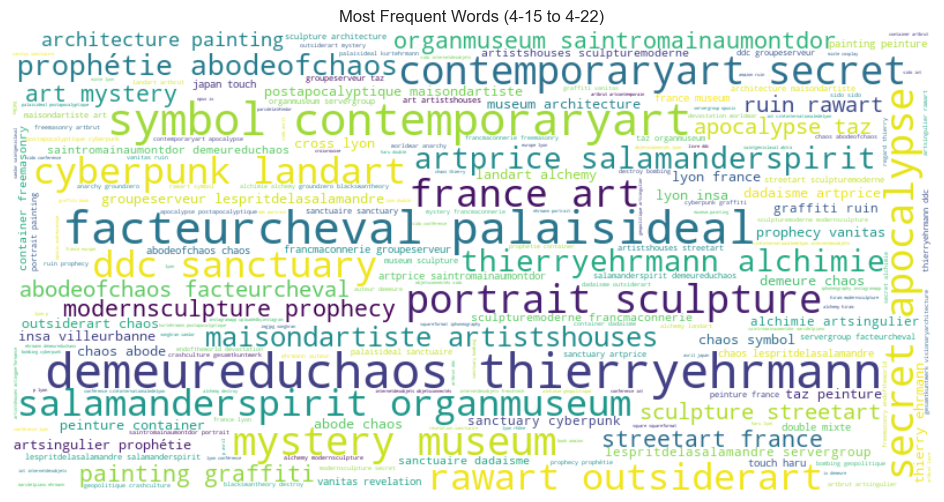

Creating Heatmap for 4-15 to 4-22 photos...
Heatmap saved as ../output/heatmap_4-15_to_4-22.html


In [25]:
data_path = "../data/cleanedTextData.csv"
df = pd.read_csv(data_path, low_memory=False, parse_dates=['date_taken'])


df['date_taken'] = pd.to_datetime(df['date_taken'], errors='coerce')


def analyze_period(first_day, first_month, last_day, last_month):
    df_period = df[
        ((df['date_taken'].dt.month == first_month) & (df['date_taken'].dt.day >= first_day)) |
        ((df['date_taken'].dt.month == last_month) & (df['date_taken'].dt.day <= last_day))
    ]

    if df_period.empty:
        print(f"No photos found between {first_month}-{first_day} and {last_month}-{last_day}.")
        return

    print(f"Total photos between {first_month}-{first_day} and {last_month}-{last_day}: {len(df_period)}")

    df_period = df_period.dropna(subset=['combined_text'])

    all_text = " ".join(df_period['combined_text'])

    excluded_words = {"lyon", "france", "image", "img", "photo", "flickr", "city", "picture", "rhône", "alpes",
                      "ville", "tourism", "urban", "travel", "place", "dsc", "dor", "imgjpg", "fr", "sec",
                      "iphoneography", "uploadedbyinstagram", "instagramapp", "instagram", "frankreich",
                      "rhônealpes", "auvergnerhônealpes", "frankrijk", "francia", "frança"}

    vectorizer = CountVectorizer(stop_words=list(excluded_words), max_features=30)
    word_matrix = vectorizer.fit_transform([all_text])
    word_counts = word_matrix.toarray().sum(axis=0)
    top_words = dict(zip(vectorizer.get_feature_names_out(), word_counts))

    sorted_words = sorted(top_words.items(), key=lambda x: x[1], reverse=True)

    print(f"Top 10 words for {first_month}-{first_day} to {last_month}-{last_day}:")
    for word, count in sorted_words[:10]:
        print(f"{word}: {count}")

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Most Frequent Words ({first_month}-{first_day} to {last_month}-{last_day})")
    plt.show()



    print(f"Creating Heatmap for {first_month}-{first_day} to {last_month}-{last_day} photos...")
    map_period = folium.Map(location=[45.75, 4.85], zoom_start=13)
    heat_data = df_period[['lat', 'long']].dropna().values.tolist()
    HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(map_period)

    map_file = f"../output/heatmap_{first_month}-{first_day}_to_{last_month}-{last_day}.html"
    map_period.save(map_file)
    print(f"Heatmap saved as {map_file}")

    webbrowser.open(f'file:///{os.path.abspath(map_file)}')


first_day = 15
first_month = 4
last_day = 22
last_month = 4

analyze_period(first_day, first_month, last_day, last_month)

To enhance our analysis, we have implemented a Traveling Salesman Problem (TSP) algorithm to compute the shortest route between different clusters. This allows us to generate an optimized itinerary for visiting Lyon’s main points of interest, ensuring efficient travel between them. By leveraging our DBSCAN clustering results, we can now propose optimized sightseeing routes that help visitors explore the most significant locations with minimal travel time.


## Bonus : TSP on clusters centers

In [26]:
# Ensure latitude and longitude values are floats
cluster_centroids = {
    cluster_id: (float(coords['lat']), float(coords['long'])) 
    for cluster_id, coords in cluster_centroids.items()
}

# Define the geographical boundaries of the Presqu'île area in Lyon
presquile_bounds = {
    "lat_min": 45.743,  # South of Perrache
    "lat_max": 45.774,  # Northern part of Presqu'île near Hôtel de Ville
    "lon_min": 4.815,   # Confluence district to the west
    "lon_max": 4.850    # Cordeliers district to the east
}

# Filter clusters to keep only those within the Presqu'île
presquile_centroids = {
    cluster_id: (lat, long) 
    for cluster_id, (lat, long) in cluster_centroids.items()
    if presquile_bounds["lat_min"] <= lat <= presquile_bounds["lat_max"] and 
       presquile_bounds["lon_min"] <= long <= presquile_bounds["lon_max"]
}

print(f"Number of clusters in Presqu'île: {len(presquile_centroids)}")

# Check if enough clusters are detected
if len(presquile_centroids) < 2:
    print("Not enough clusters detected in Presqu'île. Check DBSCAN parameters.")
else:
    # Convert filtered centroids into a list of GPS points
    tourist_sites = list(presquile_centroids.values())

    # Build the distance matrix between each location
    n = len(tourist_sites)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i, j] = great_circle(tourist_sites[i], tourist_sites[j]).kilometers

    G = nx.complete_graph(n)
    for i, j in G.edges:
        G[i][j]['weight'] = distance_matrix[i, j]
    tsp_path = list(nx.approximation.traveling_salesman_problem(G, cycle=True))
    tsp_distance = sum(distance_matrix[tsp_path[i], tsp_path[i+1]] for i in range(len(tsp_path)-1))

    print(f"Optimal path found: {tsp_path} with a total distance of {tsp_distance:.2f} km")

    # Add the itinerary to the Folium map
    for i in range(len(tsp_path) - 1):
        point1 = tourist_sites[tsp_path[i]]
        point2 = tourist_sites[tsp_path[i+1]]
        folium.PolyLine([point1, point2], color="blue", weight=2.5, opacity=1).add_to(map_clusters)

    # Add the return path to the starting point
    folium.PolyLine([tourist_sites[tsp_path[-1]], tourist_sites[tsp_path[0]]], color="blue", weight=2.5, opacity=1).add_to(map_clusters)

    # Save and display the updated map
    map_file = "../output/clusteringDBSCAN.html"
    map_clusters.save(map_file)
    print(f"Tourist route map on Presqu'île saved in {map_file}")

    # Automatically open the map
    webbrowser.open(f'file:///{os.path.abspath(map_file)}')

Number of clusters in Presqu'île: 74
Optimal path found: [0, 45, 30, 71, 20, 72, 10, 38, 7, 36, 65, 51, 28, 62, 42, 66, 35, 37, 15, 53, 3, 31, 61, 44, 6, 8, 14, 26, 43, 52, 33, 11, 58, 5, 49, 23, 12, 16, 29, 48, 24, 68, 17, 50, 40, 1, 54, 32, 73, 39, 21, 56, 70, 63, 60, 55, 64, 34, 25, 27, 46, 67, 41, 69, 57, 59, 2, 4, 22, 47, 19, 9, 18, 13, 0] with a total distance of 18.31 km
Tourist route map on Presqu'île saved in ../output/clusteringDBSCAN.html


## Conclusion

In this notebook, we conducted a comprehensive spatial and textual analysis of a dataset containing geolocated photos taken in Lyon. Our approach followed several key steps:

- **Data Cleaning & Preprocessing** – We ensured that our dataset was structured, filtered, and formatted correctly, removing noise and irrelevant data.
- **Descriptive Statistics** – We explored the dataset through visualizations to gain insights into temporal and spatial distributions.
- **Clustering Analysis** – We applied three different clustering methods (K-Means, Hierarchical Clustering, and DBSCAN), ultimately selecting **DBSCAN** due to its ability to detect meaningful points of interest while handling noise effectively.
- **Text Mining** – We extracted keywords from the clustered photos, allowing us to assign descriptive names to each cluster, making the data more interpretable.
- **Temporal and Spatial Correlations** – We investigated recurring events in Lyon by analyzing time-based trends, particularly identifying the significance of the Fête des Lumières in early December.
- **Custom Event Exploration** – We extended our approach to allow date-specific analysis, enabling users to explore what happens in Lyon at different times of the year.
- **Optimal Tourist Path (TSP Algorithm)** – Finally, we implemented an algorithm to compute the shortest route between key locations, creating an optimized itinerary for visiting major points of interest.

This analysis has proven to be highly relevant for understanding Lyon’s main attractions and events. The methodology we developed is scalable and could be applied to any city given an appropriate dataset. This could be valuable for travel planning, urban analysis, or even event forecasting. Future improvements could include integrating real-time data or refining the clustering parameters to further enhance the accuracy of detected points of interest.
